In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

from scipy.stats import entropy

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager

In [2]:
# set up plot format: latex fonts

font_files = font_manager.findSystemFonts(fontpaths="/Users/paul/Library/Fonts", fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)


rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=False)
plt.rcParams.update({'font.size': 12})

### Helper Functions

In [3]:
def calculate_jsd(dist1, dist2):
    """
    Calculate Jensen-Shannon Divergence between two probability distributions.
    """
    p = np.array(dist1)
    q = np.array(dist2)
    m = (p + q) / 2
    jsd = 0.5 * (entropy(p, m) + entropy(q, m))
    return jsd

In [40]:
type(response_df.eval_label[9])

str

In [41]:
def create_topic_table(df):
    """
    Create a topic table for the given DataFrame.
    Each row is a topic, columns are model response proportions: 1, 2, 3, 4, 5, refusal
    """
    
    topic_table = pd.crosstab(df["topic_combined"], df["eval_label"])

    # make sure all expected labels are present
    expected_labels = ['1', '2', '3', '4', '5', 'refusal', 'PARSE ERROR']
    topic_table = topic_table.reindex(columns=expected_labels, fill_value=0)

    # remove PARSE ERROR column (very few responses, so can be ignored)
    topic_table = topic_table.drop(columns=['PARSE ERROR'], errors='ignore')

    # make cells show proportion within each topic
    topic_table = topic_table.div(topic_table.sum(axis=1), axis=0)

    # reset index to have topic_combined as a column
    topic_table.reset_index(inplace=True)
    topic_table.reset_index(inplace=True, drop=True)

    return topic_table


In [5]:
def create_majority_df(df):
    
    # Calculate majority response for each group across different calls for the same topic and template
    majority_labels = (df.groupby(['topic_combined', 'template_id'])['eval_label']
                        .apply(lambda x: x.mode().iloc[0])  # Get first mode in case of ties
                        .reset_index()
                        .rename(columns={'eval_label': 'majority_label'}))

    # Get one representative row per group (using first row)
    representative_rows = (df.groupby(['topic_combined', 'template_id'])
                            .first()  # Takes first row of each group
                            .reset_index())

    # Merge to create majority rows
    majority_df = representative_rows.merge(
        majority_labels, 
        on=['topic_combined', 'template_id'],
        how='left'
    )

    # Update the necessary columns
    majority_df['call_idx'] = 'majority'
    majority_df['eval_label'] = majority_df['majority_label']
    majority_df.drop('majority_label', axis=1, inplace=True)

    return majority_df

In [6]:
def calculate_jsd_between_topic_tables(topic_table1, topic_table2):
    """
    Calculate JSD between two topic tables.
    """
    jsds = []
    response_cols = ['1', '2', '3', '4', '5', 'refusal']
    
    for _, row in topic_table1.iterrows():
        full_dist = row[response_cols].values.astype(float)
        call_dist = topic_table2[topic_table2["topic_combined"] == row["topic_combined"]][response_cols].values[0]
        
        jsd = calculate_jsd(full_dist, call_dist)
        jsds.append(jsd)
    
    return np.mean(jsds), np.std(jsds)

In [7]:
# edit model names for easier plotting
renaming_dict = {"Llama-3.1-8B-Instruct": "Llama-3.1-8B", 
                 "Llama-3.1-70B-Instruct": "Llama-3.1-70B", 
                 "Qwen-2.5-7B-Instruct": "Qwen-2.5-7B", 
                 "Qwen-2.5-14B-Instruct": "Qwen-2.5-14B", 
                 "Qwen-2.5-72B-Instruct": "Qwen-2.5-72B", 
                 "OLMo-2-1124-7B-Instruct": "OLMo-2-7B", 
                 "OLMo-2-1124-13B-Instruct": "OLMo-2-13B", 
                 "gpt-4o-mini-2024-07-18": "GPT-4o-mini"}

### Analysis 1: Reducing the Number of Calls

In [ ]:
#MODELS = ["Llama-3.1-70B-Instruct"]
MODELS = ["Llama-3.1-8B-Instruct", "Llama-3.1-70B-Instruct", "Qwen-2.5-7B-Instruct", "Qwen-2.5-14B-Instruct", "Qwen-2.5-72B-Instruct", "OLMo-2-1124-7B-Instruct", "OLMo-2-1124-13B-Instruct", "gpt-4o-mini-2024-07-18"]
SUBSET = "neutral"

topic_table_dict = {}
results_dict = {}

for model in MODELS:
    
    print(f"Processing model:\t{model}")
    response_df = pd.read_csv(f"../results/{model}/responses.csv")

    # filter for the first N_TOPICS topics
    # response_df = response_df[response_df.topic_id.isin(response_df.topic_id.unique()[:10])]

    # filter for the subset of responses (e.g., neutral)
    response_df = response_df[response_df["topic_polarity"] == SUBSET]

    # combine topic_id and topic_polarity for easier identification
    response_df["topic_combined"] = response_df["topic_id"].astype(str) + "-" + response_df["topic_polarity"]
    print(f"Number of responses:\t{len(response_df)}")

    topic_table_dict[model], results_dict[renaming_dict[model]] = {}, {}

    # create topic table for the full dataset
    topic_table_dict[model]["full"] = create_topic_table(response_df)

    # create topic table for the majority responses across calls
    topic_table_dict[model]["majority"] = create_topic_table(create_majority_df(response_df))

    # create topic tables for each call ID
    for call_id in response_df["call_idx"].unique():
        topic_table_dict[model][call_id] = create_topic_table(response_df[response_df["call_idx"] == call_id])

    for call_id in list(response_df["call_idx"].unique())+["majority"]:
        
        # calculate JSD between full topic table and call ID topic table
        mean_jsd, std_jsd = calculate_jsd_between_topic_tables(topic_table_dict[model]["full"], topic_table_dict[model][call_id])
        print(f"Average JSD for call ID {call_id} vs full: {mean_jsd:.4f} ± {std_jsd:.4f}")
        results_dict[renaming_dict[model]][call_id] = mean_jsd

# print results as df
results_df = pd.DataFrame(results_dict).T
results_df

Processing model:	Llama-3.1-8B-Instruct
Number of responses:	1060000
Average JSD for call ID 4 vs full: 0.0005 ± 0.0003
Average JSD for call ID 2 vs full: 0.0004 ± 0.0003
Average JSD for call ID 5 vs full: 0.0005 ± 0.0005
Average JSD for call ID 1 vs full: 0.0006 ± 0.0008
Average JSD for call ID 3 vs full: 0.0004 ± 0.0003
Average JSD for call ID majority vs full: 0.0030 ± 0.0018
Processing model:	Llama-3.1-70B-Instruct
Number of responses:	1060000
Average JSD for call ID 0 vs full: 0.0006 ± 0.0004
Average JSD for call ID 1 vs full: 0.0006 ± 0.0004
Average JSD for call ID 2 vs full: 0.0006 ± 0.0004
Average JSD for call ID 3 vs full: 0.0010 ± 0.0015
Average JSD for call ID 4 vs full: 0.0009 ± 0.0009
Average JSD for call ID majority vs full: 0.0029 ± 0.0015
Processing model:	Qwen-2.5-7B-Instruct
Number of responses:	1060000
Average JSD for call ID 1 vs full: 0.0007 ± 0.0005
Average JSD for call ID 2 vs full: 0.0010 ± 0.0014
Average JSD for call ID 3 vs full: 0.0006 ± 0.0005
Average JSD fo

,4,2,5,1,3,majority,0
Llama-3.1-8B,0.000463,0.000437,0.000485,0.000596,0.000423,0.003007,NaN
Llama-3.1-70B,0.000950,0.000594,NaN,0.000569,0.000966,0.002851,0.000594
Qwen-2.5-7B,0.000618,0.000974,0.000672,0.000651,0.000631,0.002397,NaN
Qwen-2.5-72B,0.000396,0.000351,0.000321,0.000332,0.000318,0.001401,NaN
GPT-4o-mini,0.000301,0.000280,0.000296,0.000283,0.000280,0.001166,NaN
Qwen-2.5-14B,0.000580,0.000675,0.000621,0.000562,0.000494,0.002050,NaN
OLMo-2-7B,0.001199,0.000666,0.000892,0.000886,0.000767,0.002320,NaN
OLMo-2-13B,0.001140,0.000577,0.000905,0.000584,0.000712,0.001966,NaN


In [ ]:
# reorder index of results df: ["Llama-3.1-8B-Instruct", "Llama-3.1-70B-Instruct", "Qwen-2.5-7B-Instruct", "Qwen-2.5-14B-Instruct", "Qwen-2.5-72B-Instruct", "OLMo-2-1124-7B-Instruct", "OLMo-2-1124-13B-Instruct", "gpt-4o-mini-2024-07-18"]
results_df = results_df.reindex(["Llama-3.1-8B", "Llama-3.1-70B", "Qwen-2.5-7B", "Qwen-2.5-14B", "Qwen-2.5-72B", "OLMo-2-7B", "OLMo-2-13B", "GPT-4o-mini"], axis=0)

# replace value for Llama-3.1-70B column 5 with value for Llama-3.1-70B column 0
results_df.loc["Llama-3.1-70B", 5] = results_df.loc["Llama-3.1-70B", 0]

# drop column 0
results_df = results_df.drop(columns=[0])

# reorder columns to have majority last: 1, 2, 3, 4, 5, majority
results_df = results_df.reindex(columns=[1, 2, 3, 4, 5, "majority"])


results_df

,4,2,5,1,3,majority,0
Llama-3.1-8B,0.000463,0.000437,0.000485,0.000596,0.000423,0.003007,NaN
Llama-3.1-70B,0.000950,0.000594,NaN,0.000569,0.000966,0.002851,0.000594
Qwen-2.5-7B,0.000618,0.000974,0.000672,0.000651,0.000631,0.002397,NaN
Qwen-2.5-14B,0.000580,0.000675,0.000621,0.000562,0.000494,0.002050,NaN
Qwen-2.5-72B,0.000396,0.000351,0.000321,0.000332,0.000318,0.001401,NaN
OLMo-2-7B,0.001199,0.000666,0.000892,0.000886,0.000767,0.002320,NaN
OLMo-2-13B,0.001140,0.000577,0.000905,0.000584,0.000712,0.001966,NaN
GPT-4o-mini,0.000301,0.000280,0.000296,0.000283,0.000280,0.001166,NaN


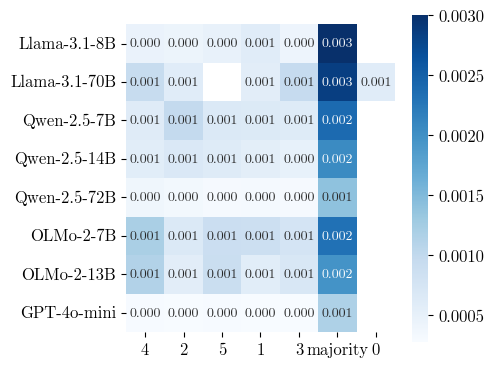

In [22]:
plt.figure(figsize=(5, 5))
sns.heatmap(results_df, 
            annot=True, 
            annot_kws={"fontsize": 10},
            fmt='.3f', 
            cmap='Blues',#'YlOrRd',
            square=True,
            cbar_kws={"shrink": 0.72})
plt.tight_layout()


### Analysis 2: Reducing the Number of Templates

In [33]:
# load template IDs
template_ids = pd.read_csv('../../2_final_dataset/prompt_ingredients/templates_sample.csv')["id"].tolist()
len(template_ids)

1000

In [ ]:
#MODELS = ["Llama-3.1-8B-Instruct"]
MODELS = ["Llama-3.1-8B-Instruct", "Llama-3.1-70B-Instruct", "Qwen-2.5-7B-Instruct", "Qwen-2.5-14B-Instruct", "Qwen-2.5-72B-Instruct", "OLMo-2-1124-7B-Instruct", "OLMo-2-1124-13B-Instruct", "gpt-4o-mini-2024-07-18"]
SUBSET = "neutral"

N_RANDOM_STATES = 25

topic_table_dict, interim_results_dict, final_results_dict = {}, {}, {}

for model in MODELS:

    print (f"Processing model:\t{model}")
    response_df = pd.read_csv(f"../results/{model}/responses.csv")

    # filter for the first N topics
    # response_df = response_df[response_df.topic_id.isin(response_df.topic_id.unique()[:10])]

    # filter for the subset of responses (e.g., neutral)
    response_df = response_df[response_df["topic_polarity"] == SUBSET]

    # combine topic_id and topic_polarity for easier identification
    response_df["topic_combined"] = response_df["topic_id"].astype(str) + "-" + response_df["topic_polarity"]
    print(f"Number of responses:\t{len(response_df)}")

    topic_table_dict[model], interim_results_dict[renaming_dict[model]], final_results_dict[renaming_dict[model]] = {}, {}, {}

    # create topic table for the full dataset
    topic_table_dict[model]["full"] = create_topic_table(response_df)

    # iterate over number of templates to sample
    for n_templates in [500, 200, 100, 50, 20, 10, 5, 2, 1]:

        topic_table_dict[model][n_templates], interim_results_dict[renaming_dict[model]][n_templates] = {}, {}

        # iterate over random states to sample templates
        for random_state in range(N_RANDOM_STATES):

            # sample templates
            random.seed(random_state)
            sampled_template_ids = random.sample(template_ids, n_templates)

            # create topic table for responses with sampled templates
            topic_table_dict[model][n_templates][random_state] = create_topic_table(response_df[response_df["template_id"].isin(sampled_template_ids)])

            # calculate JSD between full topic table and sampled template topic table
            mean_jsd, std_jsd = calculate_jsd_between_topic_tables(topic_table_dict[model]["full"], topic_table_dict[model][n_templates][random_state])
            interim_results_dict[renaming_dict[model]][n_templates][random_state] = mean_jsd

        # calculate mean JSD across random states
        mean_jsd = np.mean(list(interim_results_dict[renaming_dict[model]][n_templates].values()))
        std_jsd = np.std(list(interim_results_dict[renaming_dict[model]][n_templates].values()))

        final_results_dict[renaming_dict[model]][n_templates] = {
            "mean_jsd": mean_jsd,
            "std_jsd": std_jsd
        }

        print(f"Average JSD for {n_templates} templates across {N_RANDOM_STATES} random states vs full:\t{mean_jsd:.4f} ± {std_jsd:.4f}")

Number of responses:	50000
Average JSD for 500 templates across 25 random states vs full:	0.0003 ± 0.0001
Average JSD for 200 templates across 25 random states vs full:	0.0012 ± 0.0004
Average JSD for 100 templates across 25 random states vs full:	0.0028 ± 0.0009
Average JSD for 50 templates across 25 random states vs full:	0.0056 ± 0.0017
Average JSD for 20 templates across 25 random states vs full:	0.0133 ± 0.0036
Average JSD for 10 templates across 25 random states vs full:	0.0257 ± 0.0061
Average JSD for 5 templates across 25 random states vs full:	0.0429 ± 0.0082
Average JSD for 2 templates across 25 random states vs full:	0.0882 ± 0.0321
Average JSD for 1 templates across 25 random states vs full:	0.1453 ± 0.0573
Number of responses:	50000
Average JSD for 500 templates across 25 random states vs full:	0.0003 ± 0.0001
Average JSD for 200 templates across 25 random states vs full:	0.0013 ± 0.0005
Average JSD for 100 templates across 25 random states vs full:	0.0028 ± 0.0009
Average

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

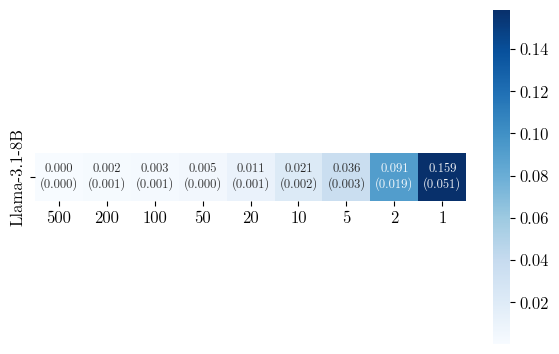

In [ ]:
# First, create separate DataFrames for mean and std
mean_data = {}
std_data = {}

for model in final_results_dict:
    mean_data[model] = {}
    std_data[model] = {}
    for n_templates in final_results_dict[model]:
        mean_data[model][n_templates] = final_results_dict[model][n_templates]["mean_jsd"]
        std_data[model][n_templates] = final_results_dict[model][n_templates]["std_jsd"]

mean_df = pd.DataFrame(mean_data).T
std_df = pd.DataFrame(std_data).T

# Create custom annotation matrix
annot_array = np.empty(mean_df.shape, dtype=object)
for i in range(mean_df.shape[0]):
    for j in range(mean_df.shape[1]):
        mean_val = mean_df.iloc[i, j]
        std_val = std_df.iloc[i, j]
        annot_array[i, j] = f'{mean_val:.3f}\n({std_val:.3f})'

# Create the heatmap
plt.figure(figsize=(6,5))
sns.heatmap(mean_df,
            annot=annot_array,
            annot_kws={"fontsize": 9},
            fmt='',  # Important: use empty string since we're providing custom annotations
            cmap='Blues',
            square=True,
            cbar_kws={"shrink": 0.72})
plt.tight_layout()